## Imports

In [1]:
import pandas as pd
import numpy as np
import shap 

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\SexyEmy\Documents\Emy documents\Thesis\gaiamachine\notebooks\emy_workspace\tests\random_forest\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading data 

In [2]:
# Load data
df = pd.read_csv('dataset_full.csv')
df

,source_id,ra,dec,parallax,parallax_error,pmra,pmdec,visibility_periods_used,radial_velocity,radial_velocity_error,...,goodness_of_fit,efficiency,significance,binary,p1_a0_mas,mass_function_msun,p1_omega_deg,p1_OMEGA_deg,p1_incl_deg,absolute_phot_g_mean_mag
0,43574131143039104,58.175979,17.014957,103.500794,0.088199,433.182995,-645.368619,17,35.963917,1.782843,...,1.629151,0.324866,37.891860,0,1.391085,2.888966e-03,1.595165,2.837831,1.620010,46.905221
1,73648110622521600,32.726916,12.540392,17.076489,0.072694,-135.806282,-31.435695,15,0.571379,4.496880,...,-0.426033,0.287160,22.225372,1,1.011235,1.148423e-04,1.364675,1.332473,1.980661,41.099891
2,198464052134353536,72.240908,36.804835,41.543454,0.088188,-8.027858,-366.251059,17,0.000000,1.118017,...,4.924189,0.000000,14.872245,1,1.110470,2.802633e-05,2.199991,3.020659,2.040339,44.541183
3,246890014559489792,58.965810,47.846416,19.038653,0.029674,18.644739,-64.016779,21,-16.496304,4.997410,...,6.516918,0.000000,7.904773,1,0.364730,1.377426e-06,1.806250,0.599547,0.586254,40.640959
4,373892712892466048,13.402764,39.475380,13.283684,0.033895,-49.317068,12.214163,18,-23.901018,1.500977,...,1.606543,0.000000,17.364326,1,0.395497,1.546028e-05,1.844566,1.951415,0.720391,38.269705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,5765846127180770432,198.836956,-87.561378,40.475727,0.014570,-222.290438,-156.170870,25,-4.870909,0.125114,...,0.722993,0.000000,4.704921,1,0.835499,2.926069e-03,1.344845,2.932008,0.955993,36.968836
80,5855730584310531200,192.215965,-68.424652,34.609402,0.023909,27.283468,112.918312,24,104.531510,0.128428,...,0.596801,0.271469,15.989910,0,0.511159,5.523343e-07,0.981089,0.566526,1.685887,36.636047
81,5999024986946599808,231.345618,-46.643673,9.731272,0.036547,-65.372438,-202.569720,17,-12.348613,0.596598,...,0.192776,0.000000,26.233637,0,0.469774,2.548256e-04,2.364993,2.470896,2.233304,33.408971
82,6421118739093252224,285.003386,-69.945093,14.042105,0.022930,-7.233850,-191.894823,29,4.582623,0.122446,...,-0.490107,0.000000,9.826139,0,0.219718,6.327615e-07,2.069437,2.485763,0.492263,32.583801


## Dataset analysis

In [3]:
# Knowing the count per class
print(f"Count class 0 'substellar' : {len(df[df.binary==0])}")
print(f"Count class 1 'binary' : {len(df[df.binary==1])}")

Count class 0 'substellar' : 39
Count class 1 'binary' : 45


### Stratified K-fold CV

In [4]:
X = df.drop(columns=['source_id', 'nss_solution_type', 'binary'])
y = df['binary']

In [5]:
model = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [6]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5]
}

In [7]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [8]:
scores = cross_val_score(grid_search, X, y, cv=cv, scoring='accuracy')

print(f'Accuracy scores per fold: {scores}')
print(f'Average accuracy: {np.mean(scores)}')
print(f'Standard deviation of accuracy: {np.std(scores)}')

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Accuracy scores per fold: [0.64705882 0.70588235 0.70588235 0.70588235 0.75      ]
Average accuracy: 0.7029411764705883
Standard deviation of accuracy: 0.03275155507547071


In [9]:
y_pred_cv = cross_val_predict(grid_search, X, y, cv=cv)
y_pred_cv

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1])

In [10]:
best_params = grid_search.fit(X, y).best_params_
print("Best parameters found by GridSearchCV:")
print(best_params)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best parameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.6}


In [11]:
model = xgb.XGBClassifier(**best_params, random_state=42)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
#Predict on unseen data
df_unseen = pd.read_csv('dataset_unseen.csv')
df_unseen = df_unseen.drop(columns=['source_id', 'nss_solution_type'])

predictions = model.predict(df_unseen)
print(predictions)

[1 1 1 0]


#### Confusion matrix

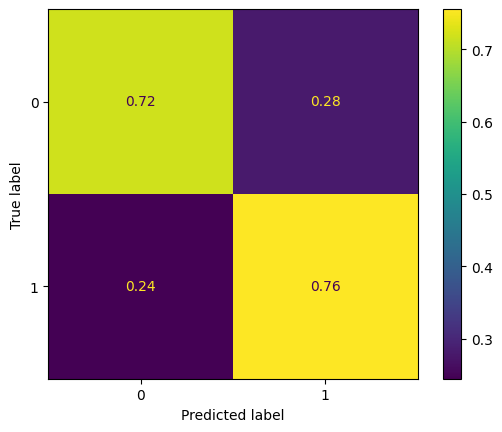

In [13]:
cm = confusion_matrix(y, y_pred_cv, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = cm).plot();

In [14]:
print(classification_report(y, y_pred_cv))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        39
           1       0.76      0.76      0.76        45

    accuracy                           0.74        84
   macro avg       0.74      0.74      0.74        84
weighted avg       0.74      0.74      0.74        84



#### Feature importance

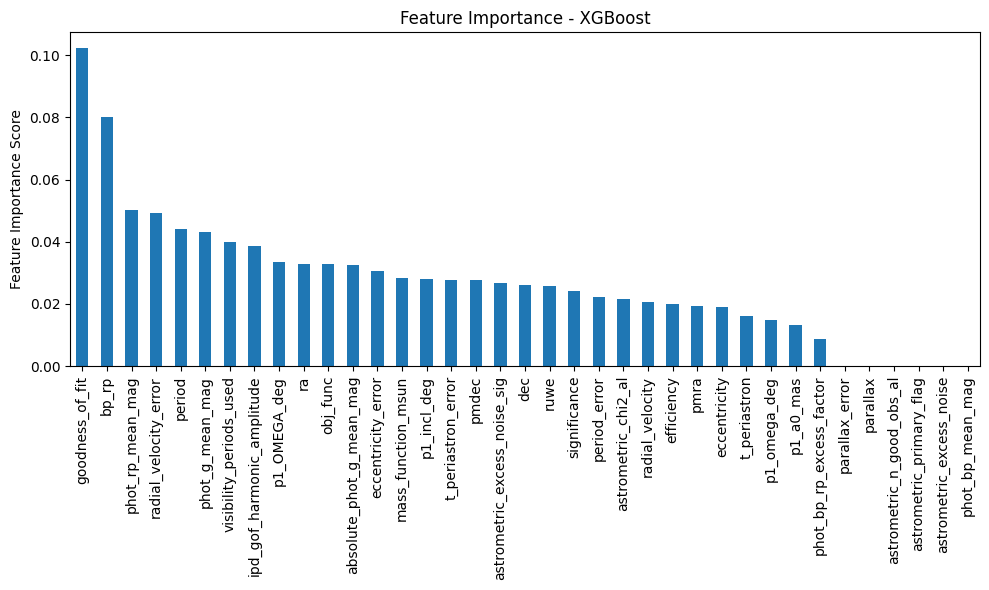

In [19]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
feature_importances.plot.bar(ax=ax);
ax.set_title("Feature Importance - XGBoost")
ax.set_ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

#### SHAP feauture importance

In [ ]:
plt.figure(figsize=(10, 6))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_matrix = shap_values[1]
else:
    shap_matrix = shap_values

shap_df = pd.DataFrame(shap_matrix, columns=X.columns)
top_10_features = shap_df.abs().mean().nlargest(5).index.tolist()

shap_top10 = shap_df[top_10_features].values
X_top10 = X[top_10_features]

explanation_top10 = shap.Explanation(
    values=shap_top10,
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
             else explainer.expected_value,
    data=X_top10.values,
    feature_names=top_10_features
)

shap.plots.beeswarm(
    explanation_top10, 
    show=False,
    plot_size=(10, 6),
)

plt.title("Feature Importance Using SHAP Values - XGBoost", fontsize=14, pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)

plt.tight_layout(pad=2)
plt.show()